<a href="https://colab.research.google.com/github/KenichiQaz/ML_Learning/blob/main/own_try11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython.display import display,HTML

# Data Munging

In [2]:
from fastai.text.all import *

dls = TextDataLoaders.from_folder(untar_data(URLs.IMDB), valid='test')

In [3]:
path = untar_data(URLs.IMDB)
dls = DataBlock(
    blocks=(TextBlock.from_folder(path),CategoryBlock),
    get_y = parent_label,
    get_items=partial(get_text_files, folders=['train', 'test']),
    splitter=GrandparentSplitter(valid_name='test')
).dataloaders(path)

# Transforms

In [4]:
files = get_text_files(path, folders = ['train', 'test'])
txts = L(o.open().read() for o in files[:2000])

In [5]:
tok = Tokenizer.from_folder(path)
tok.setup(txts)
toks = txts.map(tok)
toks[0]

(#407) ['xxbos','xxmaj','this','movie','was','made','by','xxmaj','daiei','xxmaj'...]

In [6]:
num = Numericalize()
num.setup(toks)
nums = toks.map(num)
nums[0][:10]

TensorText([  2,   8,  20,  32,  30, 119,  45,   8,   0,   8])

In [7]:
nums_dec = num.decode(nums[0][:10]); nums_dec

(#10) ['xxbos','xxmaj','this','movie','was','made','by','xxmaj','xxunk','xxmaj']

In [8]:
tok.decode(nums_dec)

'xxbos xxmaj this movie was made by xxmaj xxunk xxmaj'

In [9]:
tok((txts[0], txts[1]))

((#407) ['xxbos','xxmaj','this','movie','was','made','by','xxmaj','daiei','xxmaj'...],
 (#146) ['xxbos','xxmaj','like','a','xxmaj','circle','around','the','human','condition'...])

# Custom Transform

In [10]:
def f(x:int): return x+1
tfm = Transform(f)
tfm(2),tfm(2.0)

(3, 2.0)

In [11]:
@Transform
def f(x:int): return x+1
f(2),f(2.0)

(3, 2.0)

In [12]:
class NormalizeMean(Transform):
    def setups(self, items): self.mean = sum(items)/len(items)
    def encodes(self, x): return x-self.mean
    def decodes(self, x): return x+self.mean

In [13]:
tfm = NormalizeMean()
tfm.setup([1,2,3,4,5])
start = 2
y = tfm(start)
z = tfm.decode(y)
tfm.mean,y,z

(3.0, -1.0, 2.0)

# Create Pipeline

In [14]:
tfms = Pipeline([tok, num])
t = tfms(txts[0]); t[:20]

TensorText([   2,    8,   20,   32,   30,  119,   45,    8,    0,    8, 2136,
              10,  446,   28,  103,    8, 8420,  126,   11,    8])

In [15]:
tfms.decode(t)[:100]

'xxbos xxmaj this movie was made by xxmaj xxunk xxmaj studios , known for its xxmaj gamera movies . x'

In [16]:
tls = TfmdLists(files, [Tokenizer.from_folder(path), Numericalize])

In [17]:
t = tls[0]; t[:20]

TensorText([    2,     8,    20,    30,    25,   113,    48,     8,     0,
                8,  2554,    11,   562,    29,   115,     8, 10240,   119,
               10,     8])

In [18]:
tls.decode(t)[:100]

'xxbos xxmaj this movie was made by xxmaj xxunk xxmaj studios , known for its xxmaj gamera movies . x'

# TfmdLists and Datasets

### TfmdLists

In [19]:
tls.show(t)

xxbos xxmaj this movie was made by xxmaj xxunk xxmaj studios , known for its xxmaj gamera movies . xxmaj it is about a samurai lord who was murdered by one of his own men . xxmaj he claims his throne , forcing his former 's two children to flee into the woods , where they hide near a huge stone statue for 10 years . xxmaj in those time that passed , the new samurai lord has proved to be very brutal and ruthless towards the village people and the valley . xxmaj therefore , it seems that the good people 's only hope is the stone statue , which is where a demon god sleeps ; they want the god to help them . 

 xxmaj this samurai movie brings to us traditional xxmaj japanese aspects including sword - fights , geisha and worshipers . xxmaj it is a superb and powerful story of survival and hope , with the protagonists attempting to triumph over pure evil . xxmaj it is full of excitement , particularly the parts where the children struggles to remain in hiding as the evil warlord is out to get

In [20]:
cut = int(len(files)*0.8)
splits = [list(range(cut)), list(range(cut,len(files)))]
tls = TfmdLists(files, [Tokenizer.from_folder(path), Numericalize], 
                splits=splits)

In [21]:
tls.valid[0][:20]

TensorText([    2,    19,  2071,    20,    30,    28,    13, 30884,  3076,
            34494,    23,    10,     8,    12,    20,    44,  1465,    16,
               49,     7])

In [22]:
lbls = files.map(parent_label)
lbls

(#50000) ['pos','pos','pos','pos','pos','pos','pos','pos','pos','pos'...]

In [23]:
cat = Categorize()
cat.setup(lbls)
cat.vocab, cat(lbls[0])

(['neg', 'pos'], TensorCategory(1))

In [24]:
tls_y = TfmdLists(files, [parent_label, Categorize()])
tls_y[0]

TensorCategory(1)

### Datasets

In [25]:
x_tfms = [Tokenizer.from_folder(path), Numericalize]
y_tfms = [parent_label, Categorize()]
dsets = Datasets(files, [x_tfms, y_tfms])
x,y = dsets[0]
x[:20],y

(TensorText([    2,     8,    20,    30,    25,   113,    48,     8,     0,
                 8,  2554,    11,   562,    29,   115,     8, 10240,   119,
                10,     8]), TensorCategory(1))

In [26]:
x_tfms = [Tokenizer.from_folder(path), Numericalize]
y_tfms = [parent_label, Categorize()]
dsets = Datasets(files, [x_tfms, y_tfms], splits=splits)
x,y = dsets.valid[0]
x[:20],y

(TensorText([    2,    19,  2071,    20,    30,    28,    13, 30884,  3076,
             34494,    23,    10,     8,    12,    20,    44,  1465,    16,
                49,     7]), TensorCategory(0))

In [27]:
t = dsets.valid[0]
dsets.decode(t)

("xxbos i discovered this movie with a retailer selling oop 's . xxmaj and this one surely is an xxup oop . xxmaj one year after xxmaj the xxmaj exorcist she 's back in business with this movie but what we all new was that the career of xxmaj blair never broke out , she never became a mega star . xxmaj that 's one of the reason 's many of her films are xxup oop . xxmaj she gives a good performance in this movie . xxmaj it 's about a reject not recognized by her parents and does n't have any friends . xxmaj played at an age of 15 playing a girl of 14 , that 's funny . xxmaj the movie is also known for the rape scene in the showers were they stick a broomstick up her virginity . xxmaj in most editions it 's cut out , why , i do n't know , no blood is involved , okay , xxmaj blair is butt naked but nothing is shown , no xxup t&a so nothing to offend people . xxmaj but the movie is slow , extremely slow . xxmaj it does n't happy normally to me but i almost felt asleep . xxmaj it 's just ab

In [28]:
dls = dsets.dataloaders(bs=64, before_batch=pad_input)

In [29]:
tfms = [[Tokenizer.from_folder(path), Numericalize], [parent_label, Categorize]]
files = get_text_files(path, folders = ['train', 'test'])
splits = GrandparentSplitter(valid_name='test')(files)
dsets = Datasets(files, tfms, splits=splits)
dls = dsets.dataloaders(dl_type=SortedDL, before_batch=pad_input)

In [30]:
path = untar_data(URLs.IMDB)
dls = DataBlock(
    blocks=(TextBlock.from_folder(path),CategoryBlock),
    get_y = parent_label,
    get_items=partial(get_text_files, folders=['train', 'test']),
    splitter=GrandparentSplitter(valid_name='test')
).dataloaders(path)

# SiamesePair API

In [31]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)
files = get_image_files(path/"images")

In [32]:
class SiameseImage(fastuple):
    def show(self, ctx=None, **kwargs): 
        img1,img2,same_breed = self
        if not isinstance(img1, Tensor):
            if img2.size != img1.size: img2 = img2.resize(img1.size)
            t1,t2 = tensor(img1),tensor(img2)
            t1,t2 = t1.permute(2,0,1),t2.permute(2,0,1)
        else: t1,t2 = img1,img2
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        return show_image(torch.cat([t1,line,t2], dim=2), 
                          title=same_breed, ctx=ctx)

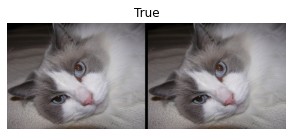

In [33]:
img = PILImage.create(files[0])
s = SiameseImage(img, img, True)
s.show();

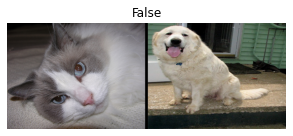

In [34]:
img1 = PILImage.create(files[1])
s1 = SiameseImage(img, img1, False)
s1.show();

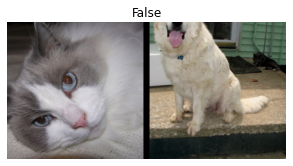

In [35]:
s2 = Resize(224)(s1)
s2.show();

In [36]:
def label_func(fname):
    return re.match(r'^(.*)_\d+.jpg$', fname.name).groups()[0]

In [37]:
class SiameseTransform(Transform):
    def __init__(self, files, label_func, splits):
        self.labels = files.map(label_func).unique()
        self.lbl2files = {l: L(f for f in files if label_func(f) == l) 
                          for l in self.labels}
        self.label_func = label_func
        self.valid = {f: self._draw(f) for f in files[splits[1]]}
        
    def encodes(self, f):
        f2,t = self.valid.get(f, self._draw(f))
        img1,img2 = PILImage.create(f),PILImage.create(f2)
        return SiameseImage(img1, img2, t)
    
    def _draw(self, f):
        same = random.random() < 0.5
        cls = self.label_func(f)
        if not same: 
            cls = random.choice(L(l for l in self.labels if l != cls)) 
        return random.choice(self.lbl2files[cls]),same

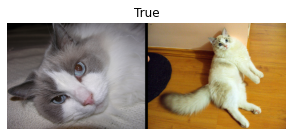

In [38]:
splits = RandomSplitter()(files)
tfm = SiameseTransform(files, label_func, splits)
tfm(files[0]).show();

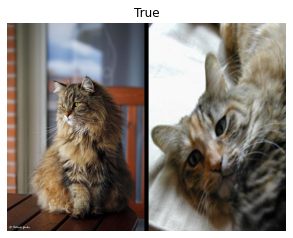

In [39]:
tls = TfmdLists(files, tfm, splits=splits)
show_at(tls.valid, 0);

In [40]:
dls = tls.dataloaders(after_item=[Resize(224), ToTensor], 
    after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])